In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import npeet.entropy_estimators as ee
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn import datasets
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
def generate_datasets(n_samples, datasets): 
    # Taken from : https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                          noise=.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(9 * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    # Default parameters.
    default_base = {'quantile': .3,
                    'eps': .3,
                    'damping': .9,
                    'preference': -200,
                    'n_neighbors': 10,
                    'n_clusters': 3,
                    'min_samples': 20,
                    'xi': 0.05,
                    'min_cluster_size': 0.1}

    data = [
        (noisy_circles, {'damping': .77, 'preference': -240,
                         'quantile': .2, 'n_clusters': 2,
                         'min_samples': 20, 'xi': 0.25}),
        (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
        (varied, {'eps': .18, 'n_neighbors': 2,
                  'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
        (aniso, {'eps': .15, 'n_neighbors': 2,
                 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
        (blobs, {}),
    ]
    
    return data

In [4]:
def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

In [5]:
def plot_settings(axes, colors, names, data):
    for i_dataset, (dataset, algo_params) in enumerate(data):
        X, y = dataset
        
        # Assumes y is in {0, ..., K}
        axes[i_dataset].scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
        axes[i_dataset].set_xticks(())
        axes[i_dataset].set_yticks(())

        axes[i_dataset].set_ylabel(names[i_dataset])

In [6]:
# Data generating parameters.
n_samples = 1000
data = generate_datasets(n_samples, datasets)

<Figure size 1512x900 with 0 Axes>

In [7]:
# colors = ["#2166ac", "#c51b7d", "#d95f02"]
# names = ['Annulus', 'Cresent Moons', 'Varied Covariance', 'Singular Covariance', 'Spread Means']

# plot_settings(axes, colors, names, data)

In [8]:
def estimate_mi(X, y, label, obj, frac_eval, base = 2):
    if label == 'UF':
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        obj.fit(X, y)
        return obj.estimate_mutual_info(X_eval)
    elif label == 'KSG':
        return ee.mi(X, np.array(y).reshape(-1, 1))
    elif label == 'Mixed KSG':
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    elif label == 'IRF':
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        obj.fit(X, y)
        
        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=base)
        
        p = obj.predict_proba(X_eval)
        H_YX = np.mean(entropy(p.T, base=base))
        return H_Y - H_YX
    else:
        raise ValueError("Uncrecognized label!")

In [9]:
def mutual_info_dist(n, frac_eval, algos, num_trials, parallel):
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        data = generate_datasets(n, datasets)
        ret = np.zeros((len(algos), len(data)))
        for i_dataset, (dataset, algo_params) in enumerate(data):
            X, y = dataset
            for j in range(len(algos)):
                ret[j, i_dataset] = estimate_mi(X, y, algos[j]['label'], algos[j]['instance'], frac_eval)
        return ret
    
    if parallel:
        predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_mutual_info = np.zeros((num_trials, len(algos), 5))
        for t in tqdm_notebook(range(num_trials)):
            predicted_mutual_info[t, :, :] = worker(t)
            
    return predicted_mutual_info

def mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = False):
    # Repeat for all 'n', and save output in the 'algos' array.
    mutual_info_range = np.zeros((len(sample_sizes), num_trials, len(algos), 5))
    for i in range(len(sample_sizes)):
        mutual_info_range[i, :, :, :] = mutual_info_dist(sample_sizes[i],
                                                         frac_eval, 
                                                         algos, 
                                                         num_trials,
                                                         parallel = parallel)
        
    for j in range(len(algos)):
        algos[j]['mutual_info_by_n'] = mutual_info_range[:, :, j, :]
        
    with open('algos_fig5.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('sample_sizes_fig5.pkl', 'wb') as f:
        pickle.dump(sample_sizes, f)

In [10]:
# Data.
sample_sizes = range(100, 120, 10)
num_trials = 3
frac_eval = 0.3
n_estimators = 5

# Algorithms.
algos = [
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': None,
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'instance': None,
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 3
parallel = True

In [11]:
mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = parallel)

In [33]:
def plot_mutual_info_by_n(axes, sample_sizes, algos, num_plotted_trials, num_settings):
    for algo in algos:
        # Plot the mean over trials as a solid line.
        for s in range(num_settings):
            axes[s].plot(sample_sizes, 
                         np.mean(algo['mutual_info_by_n'][:, :, s], axis = 1).flatten(), 
                         label = algo['label'], 
                         linewidth = 2, 
                         color = algo['color'])
            
            # Plot other trials as light lines.
            for t in range(num_plotted_trials):
                axes[s].plot(sample_sizes, 
                             algo['mutual_info_by_n'][:, t, s].flatten(),  
                             linewidth = 4, 
                             color = algo['color'],
                             alpha = 0.15)
            axes[s].set_ylim(bottom = -0.05)
            axes[s].set_ylabel("Estimated Mutual Info")
            axes[s].set_xlabel("Sample Size")

In [34]:
# TO DO: Load algos and sample sizes from disc.

# plot_mutual_info_by_n(sample_sizes, algos, num_plotted_trials)

In [45]:
def plot_fig5():
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.figure()
    plt.rcParams["font.family"] = "sans-serif"
    num_settings = 5
    
    fig, axes = plt.subplots(num_settings, 2, figsize = (14,25))
    
    colors = ["#2166ac", "#c51b7d", "#d95f02"]
    names = ['Annulus', 'Cresent Moons', 'Varied Covariance', 'Singular Covariance', 'Spread Means']
    plot_settings(axes[:,0], colors, names, generate_datasets(1000, datasets))
    plot_mutual_info_by_n(axes[:,1], sample_sizes, algos, num_plotted_trials, num_settings)
    
    axes[num_settings-1, 1].legend(loc = "lower right")
    
    plt.tight_layout()
    plt.savefig("fig5.pdf")
    plt.show()

<Figure size 432x288 with 0 Axes>

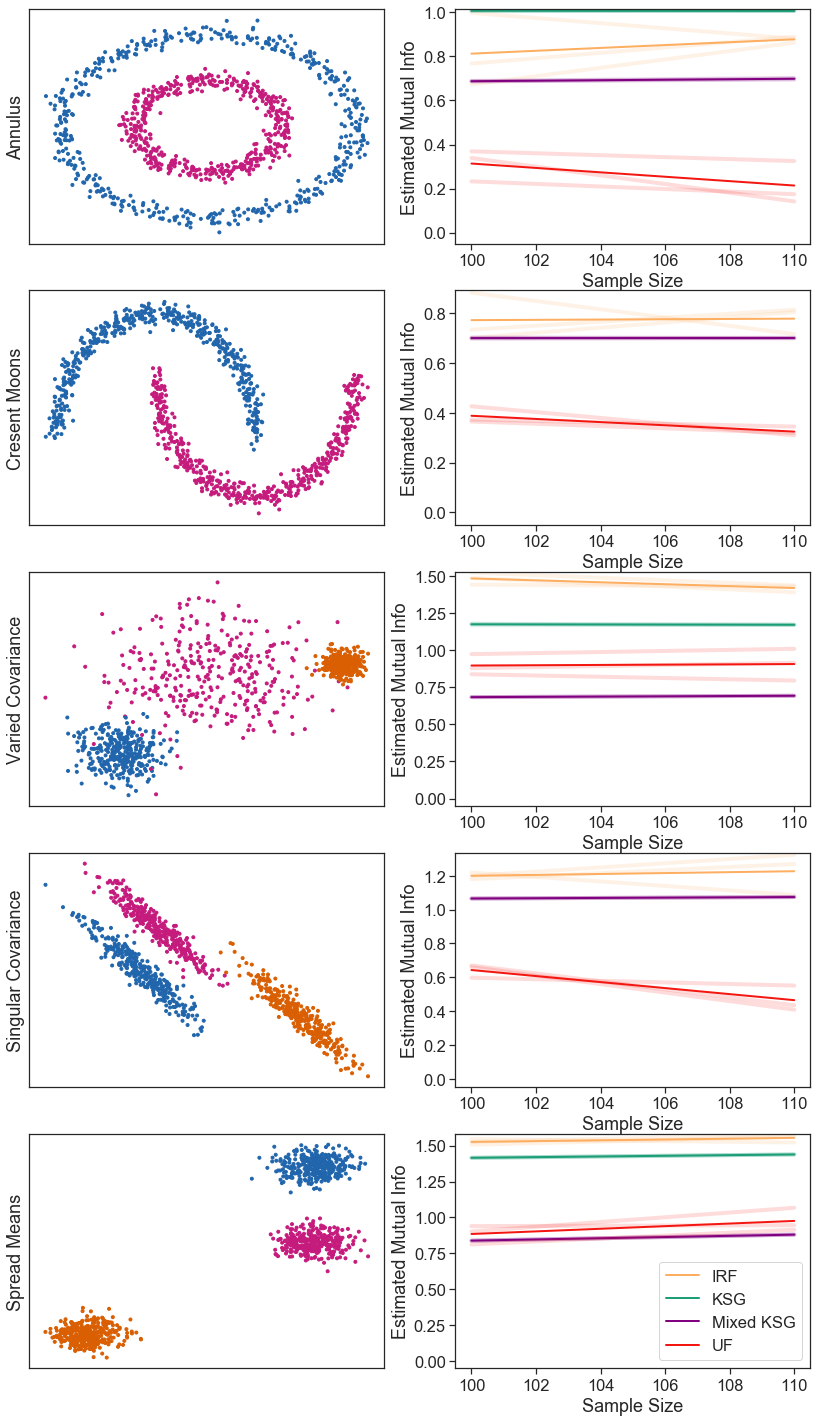

<Figure size 1512x900 with 0 Axes>

In [46]:
plot_fig5()